In [63]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mat_utils import *
from block_matrix import *
from experiments.thermal.thm_models import make_model
import porepy as pp


model = make_model(
    {
        "geometry": 2,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 0,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

# model.bmat = model.bmat[:]



Sim time: 0, Dt: 0.5
sticking: 43, sliding: 0, open: 0


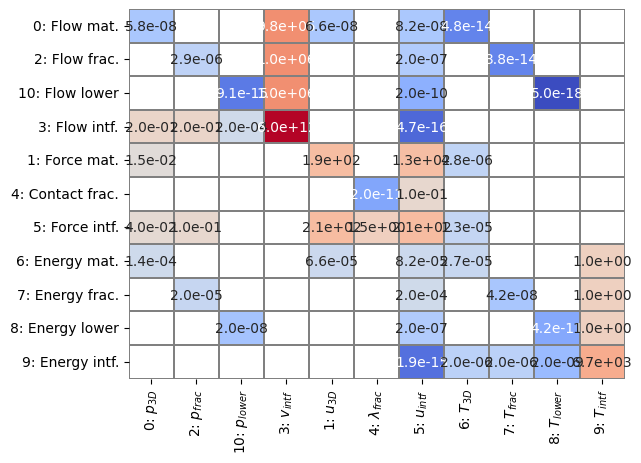

In [64]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 0, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
J = model.bmat
J = J[[0,2,10,3,1,4,5,6,7,8,9]]
J.plot_max()

Solve  took: 0.0
True residual permuted: 3.457888533418225e-11
PETSc Converged Reason: 2


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


{'mat_Q': BlockMatrixStorage of shape (1802, 1802) with 30108 elements with 8x8 active groups,
 'rhs_Q': array([0., 0., 0., ..., 0., 0., 0.]),
 'prec': <mat_utils.FieldSplit at 0x792c90f33810>}

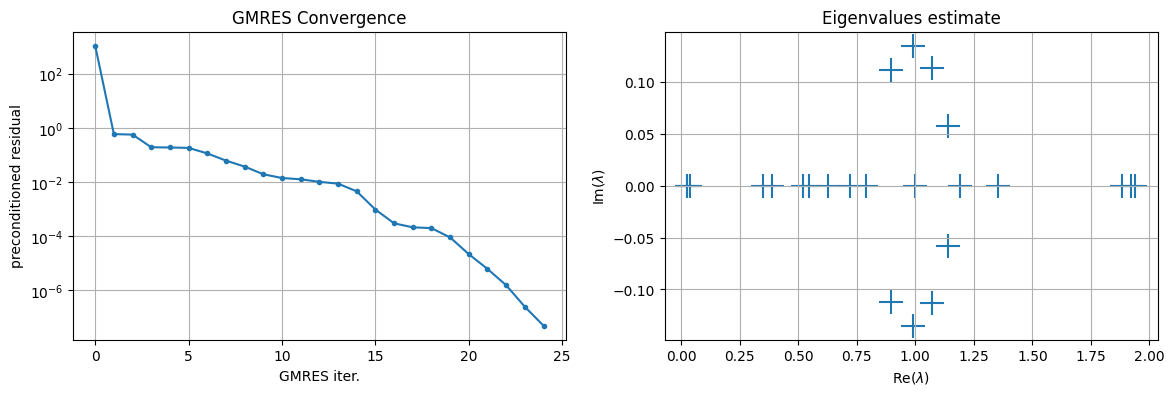

In [77]:

flow = [0,2,10]
energy = [6,7,8]
# idx = energy
# idx = flow
idx = flow + energy
intf = [3, 9]
# S = J[idx]
# S.mat = S.mat @ make_scaling(S).mat
# S.mat -= J[idx, intf].mat @ extract_diag_inv(J[intf, intf].mat) @ J[intf, idx].mat
# S.plot_max()

# prec = PetscILU(S.mat)
# prec.dot(np.ones_like(S.project_rhs_to_local(rhs)))

solve_petsc_new(
    J,
    solve_schema=FieldSplitScheme(
        groups=[3, 9],
        solve=lambda bmat: extract_diag_inv(bmat[[3, 9]].mat),
        complement=FieldSplitScheme(
            groups=idx,
            solve=lambda bmat: PetscILU(bmat[idx].mat),
        )
    ),
    rhs_global=rhs,
    Qleft=make_scaling(J),
)

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


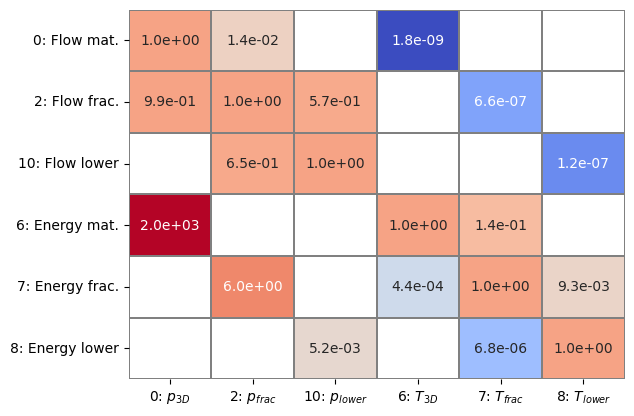

In [61]:


R = make_scaling(S)
# R.plot_max()

tmp = S.copy()
tmp.mat = S.mat @ R.mat
tmp.plot_max()

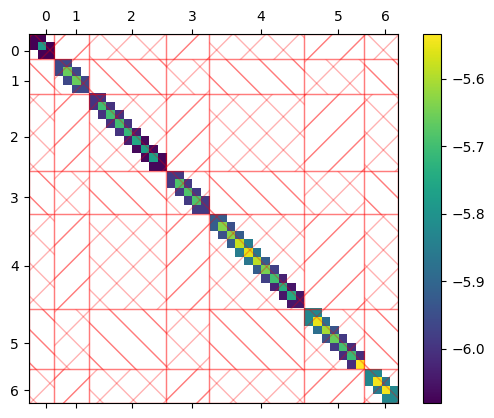

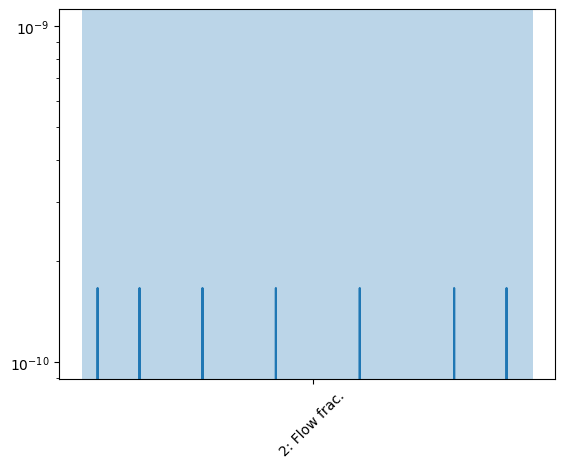

In [78]:
tmp = model.bmat[[2]]
tmp.matshow_blocks(groups=False)
tmp.color_left_vector(tmp.project_rhs_to_local(rhs))

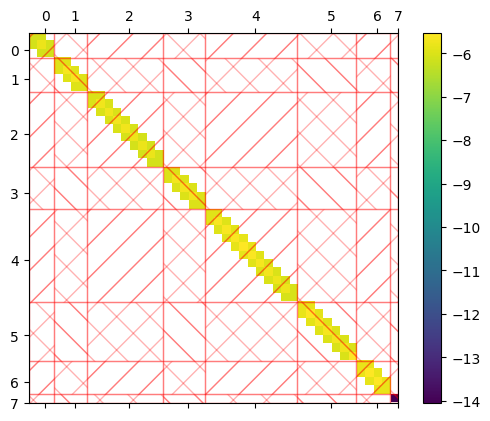

array([-6.17998168e+10, -6.18016989e+10, -6.17998168e+10, -8.30420013e+10,
       -8.30434435e+10, -8.30463280e+10, -8.30448857e+10, -3.64084437e+12,
       -3.64087309e+12, -3.64093040e+12, -3.64101616e+12, -3.64113026e+12,
       -3.64098537e+12, -3.64086770e+12, -3.64078904e+12, -3.64074959e+12,
       -1.27682278e+11, -1.27684159e+11, -1.27687921e+11, -1.27684159e+11,
       -1.27682278e+11, -9.88513696e+13, -9.88518878e+13, -9.88529900e+13,
       -9.88546103e+13, -9.88563678e+13, -9.88585625e+13, -9.88553138e+13,
       -9.88522466e+13, -9.88495915e+13, -9.88477295e+13, -9.88468022e+13,
        2.35218764e+07,  2.28514407e+07,  2.13284594e+07,  1.87337193e+07,
        1.48453938e+07,  9.72613333e+06,  3.58326370e+06, -7.20774312e+10,
       -7.20783167e+10, -7.20763446e+10, -7.20754247e+10,  1.09870942e+06])

In [86]:
from block_matrix import MultiStageScheme, FieldSplitScheme
from mat_utils import (
    RestrictedOperator,
    PetscILU,
    PetscAMGFlow,
    extract_diag_inv,
    PetscSOR,
)

# tmp.mat.data[:] = 1
# tmp.mat[-1, -1] *= 1e8
prec = PetscILU(tmp.mat)
prec.dot(np.ones_like(tmp.project_rhs_to_local(rhs_new)))
# _ = solve_petsc_new(
#     tmp,
#     solve_schema=MultiStageScheme(
#         groups=[8, 7, 2, 6, 0],
#         stages=[
#             lambda bmat: RestrictedOperator(
#                 bmat,
#                 solve_scheme=FieldSplitScheme(
#                     groups=[0, 2],
#                     solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
#                 ),
#             ),
#             lambda bmat: PetscILU(bmat.mat),
#         ],
#     ),
#     rhs_global=np.ones_like(rhs_new),
# )

# P + T no frac

In [34]:
class RearrangeAOS:

    def __init__(self, bmat: BlockMatrixStorage, solve, together: list[list[int]] = None):
        if together is None:
            together = [[i] for i in bmat.active_groups[0]]

        row_dofs = []
        col_dofs = []
        for groups in together:
            row_dofs.append(
                np.concatenate([bmat.local_dofs_row[block] for group in groups for block in bmat.groups_to_blocks_row[group]])
            )
            col_dofs.append(
                np.concatenate([bmat.local_dofs_col[block] for group in groups for block in bmat.groups_to_blocks_col[group]])
            )
        
        row_transformation = np.stack(row_dofs).ravel(order='F')
        self.Rrow = scipy.sparse.coo_matrix((np.ones_like(row_transformation), (np.arange(row_transformation.size), row_transformation))).tocsr()
        col_transformation = np.stack(col_dofs).ravel(order='F')
        self.Rcol = scipy.sparse.coo_matrix((np.ones_like(col_transformation), (col_transformation, np.arange(col_transformation.size)))).tocsr()
        self.solve = solve(self.Rrow @ bmat.mat @ self.Rcol)

    def dot(self, rhs) -> np.ndarray:
        rhs_transformed = self.Rrow @ rhs
        x_transformed = self.solve.dot(rhs_transformed)
        x = self.Rcol @ x_transformed
        return x

Solve  took: 0.0
True residual permuted: 4.3506761566004374e-16
PETSc Converged Reason: 3


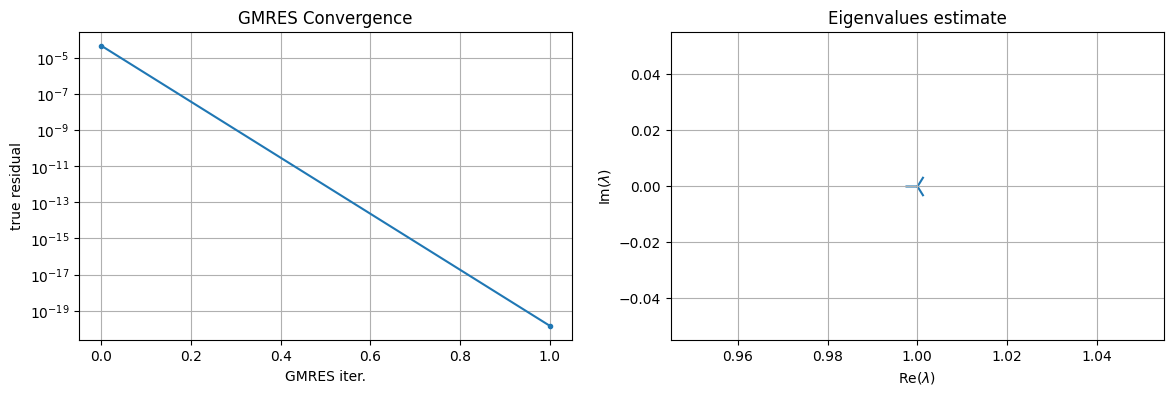

In [35]:
from block_matrix import MultiStageScheme, FieldSplitScheme
from mat_utils import (
    RestrictedOperator,
    PetscILU,
    PetscAMGFlow,
    extract_diag_inv,
    PetscSOR,
)


_ = solve_petsc_new(
    model.bmat[[6, 7, 8]],
    solve_schema=FieldSplitScheme(
        groups=[6, 7, 8],
        solve=lambda bmat: PetscILU(bmat[[6, 7, 8]].mat),
    ),
    rhs_global=rhs,
)

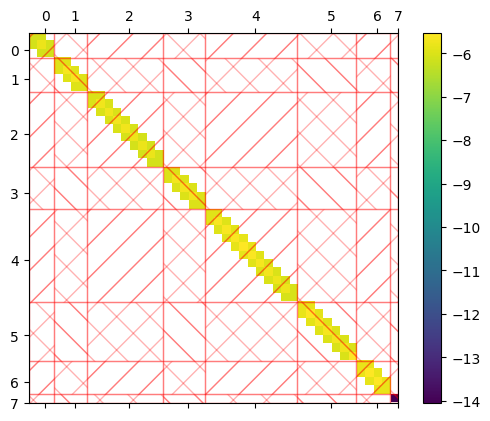

In [36]:
J[[2]].matshow_blocks(groups=False)

In [37]:
rhs_new

array([-1.94777152e-10, -5.24591255e-09, -1.75824300e-09, ...,
        2.94360890e-17, -1.58835618e-16,  1.45825192e-17])

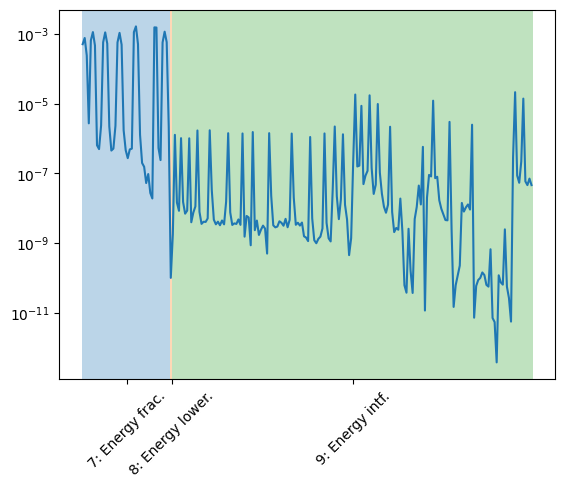

In [25]:
# rhs_new = rhs.copy()
tmp = J[[7,8,9]]
tmp.color_left_vector(tmp.project_rhs_to_local(rhs_new))

Solve  took: 0.0
True residual permuted: 1.6935724027457623e-08
PETSc Converged Reason: 3


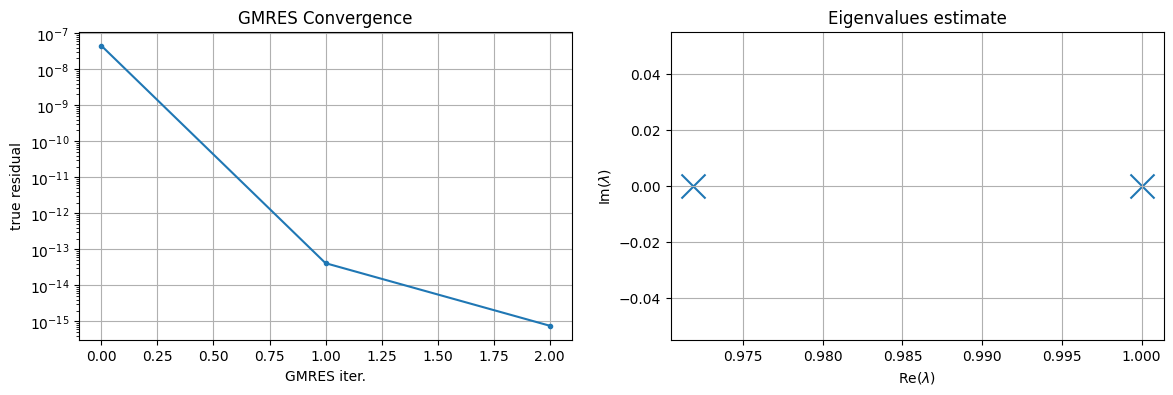

In [39]:
from block_matrix import MultiStageScheme, FieldSplitScheme
from mat_utils import RestrictedOperator, PetscILU, PetscAMGFlow, extract_diag_inv, PetscSOR

_ = solve_petsc_new(
    model.bmat[[0, 6]],
    solve_schema=MultiStageScheme(
        groups=[0, 6],
        stages=[
            lambda bmat: RestrictedOperator(
                bmat,
                solve_scheme=FieldSplitScheme(
                    groups=[0],
                    solve=lambda bmat: PetscAMGFlow(bmat[[0]].mat),
                )
            ),
            lambda bmat: PetscILU(bmat[[0, 6]].mat),
        ],
    ),
    rhs_global=rhs_new,
)

Solve  took: 0.0
True residual permuted: 1.882500298407275e-09
PETSc Converged Reason: 3


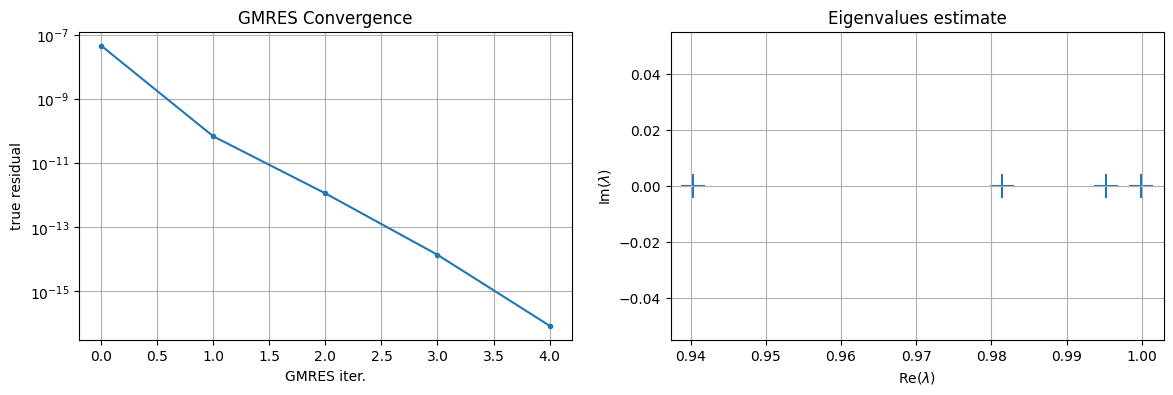

In [40]:
from mat_utils import PetscAMGVector

tmp = model.bmat[[0, 6]]
_ = solve_petsc_new(
    tmp,
    # prec=PetscILU(mat=tmp.mat),
    # prec=RearrangeAOS(tmp, solve=lambda mat: PetscILU(mat=mat)),
    # prec=PetscAMGVector(dim=1, mat=tmp.mat),
    # prec=RearrangeAOS(
    #     tmp, solve=lambda mat: PetscAMGVector(dim=2, mat=mat)
    # ),
    # solve_schema=MultiStageScheme(
    #     groups=[0, 6],
    #     stages=[
    #         lambda bmat: RestrictedOperator(
    #             bmat,
    #             solve=FieldSplitScheme(
    #                 groups=[0],
    #                 solve=lambda bmat: PetscAMGFlow(bmat[[0]].mat),
    #             )
    #         ),
    #         lambda bmat: PetscILU(bmat.mat),
    #     ],
    # ),
    solve_schema=MultiStageScheme(
        groups=[0, 6],
        stages=[
            lambda bmat: RestrictedOperator(
                bmat,
                solve_scheme=FieldSplitScheme(
                    groups=[0],
                    solve=lambda bmat: PetscAMGFlow(bmat[[0]].mat),
                )
            ),
            lambda bmat: RearrangeAOS(bmat=bmat, solve=lambda mat: PetscILU(mat)),
        ],
    ),
    rhs_global=rhs_new,
)

# P + T frac

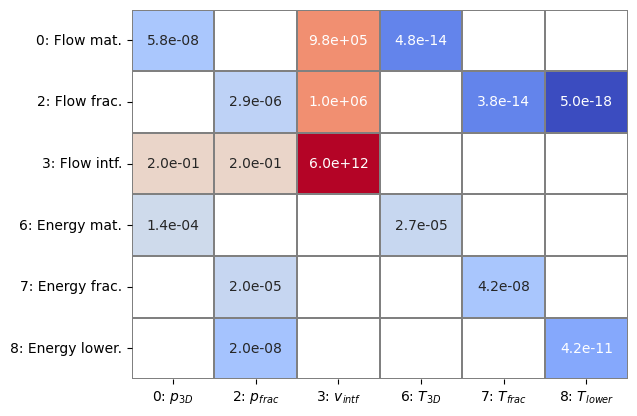

In [41]:
model.bmat[[0, 2, 3, 6, 7, 8]].plot_max()

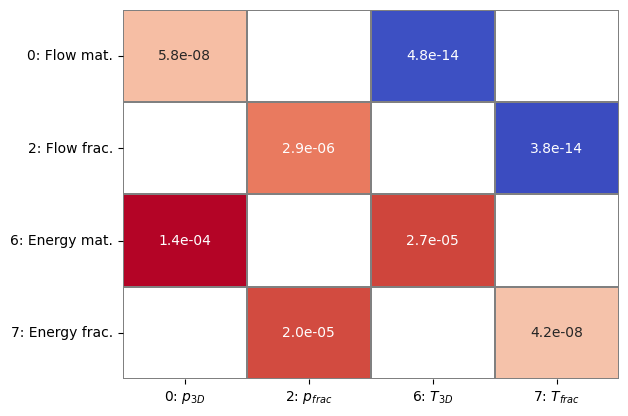

In [42]:
model.bmat[[0, 2, 6, 7]].plot_max()

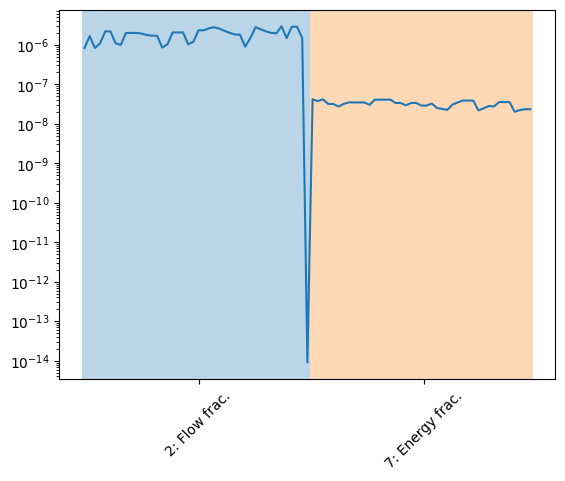

In [43]:
tmp = model.bmat[[2, 7]]
tmp.color_left_vector(tmp.mat.diagonal())

Solve  took: 0.0
True residual permuted: 4.3506761566004374e-16
PETSc Converged Reason: 3


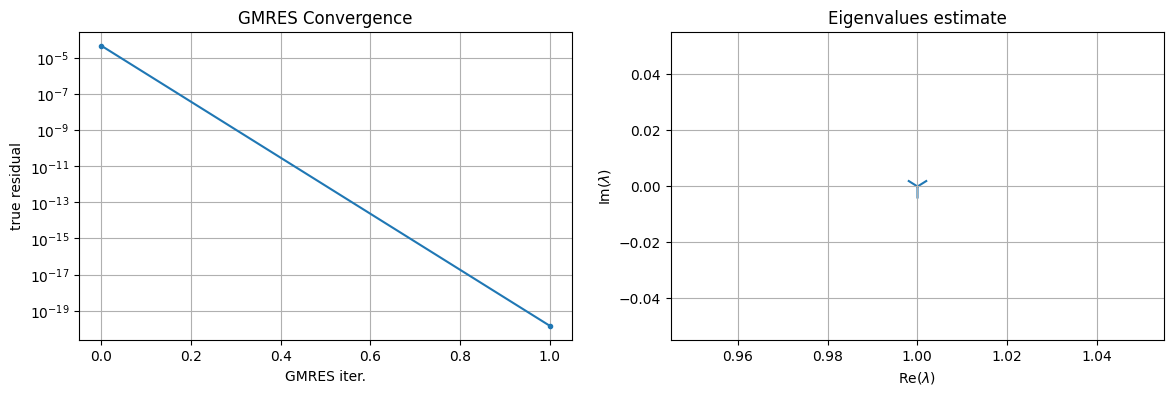

In [44]:
tmp = model.bmat[[6, 7]]
_ = solve_petsc_new(
    tmp,
    solve_schema=FieldSplitScheme(
        groups=[6, 7],
        solve=lambda bmat: PetscILU(bmat.mat),
    ),
    rhs_global=rhs,
)

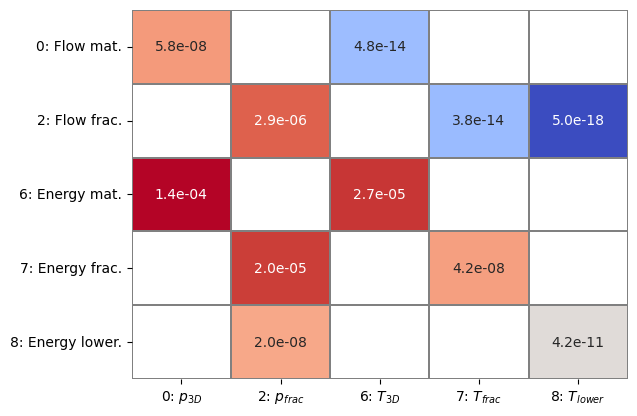

In [52]:
tmp.plot_max()

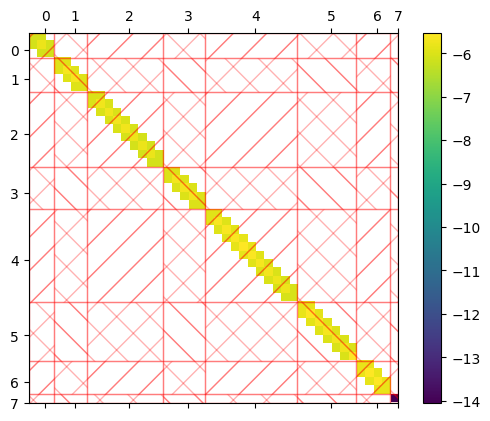

In [74]:
tmp[[2]].matshow_blocks(groups=False)

In [82]:
tmp = model.bmat[[2]]
tmp[[2]].matshow_blocks(groups=False)
# tmp.mat.data[:] = 1
tmp.mat[-1, -1] *= 1e8
prec = PetscILU(tmp.mat)
prec.dot(np.ones_like(tmp.project_rhs_to_local(rhs_new)))
# _ = solve_petsc_new(
#     tmp,
#     solve_schema=MultiStageScheme(
#         groups=[8, 7, 2, 6, 0],
#         stages=[
#             lambda bmat: RestrictedOperator(
#                 bmat,
#                 solve_scheme=FieldSplitScheme(
#                     groups=[0, 2],
#                     solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
#                 ),
#             ),
#             lambda bmat: PetscILU(bmat.mat),
#         ],
#     ),
#     rhs_global=np.ones_like(rhs_new),
# )

array([-6.17998168e+10, -6.18016989e+10, -6.17998168e+10, -8.30420013e+10,
       -8.30434435e+10, -8.30463280e+10, -8.30448857e+10, -3.64084437e+12,
       -3.64087309e+12, -3.64093040e+12, -3.64101616e+12, -3.64113026e+12,
       -3.64098537e+12, -3.64086770e+12, -3.64078904e+12, -3.64074959e+12,
       -1.27682278e+11, -1.27684159e+11, -1.27687921e+11, -1.27684159e+11,
       -1.27682278e+11, -9.88513696e+13, -9.88518878e+13, -9.88529900e+13,
       -9.88546103e+13, -9.88563678e+13, -9.88585625e+13, -9.88553138e+13,
       -9.88522466e+13, -9.88495915e+13, -9.88477295e+13, -9.88468022e+13,
        2.35218764e+07,  2.28514407e+07,  2.13284594e+07,  1.87337193e+07,
        1.48453938e+07,  9.72613333e+06,  3.58326370e+06, -7.20774312e+10,
       -7.20783167e+10, -7.20763446e+10, -7.20754247e+10,  1.09870942e+06])

# P + T frac and intf

Solve  took: 0.0
True residual permuted: 1.0
PETSc Converged Reason: -9


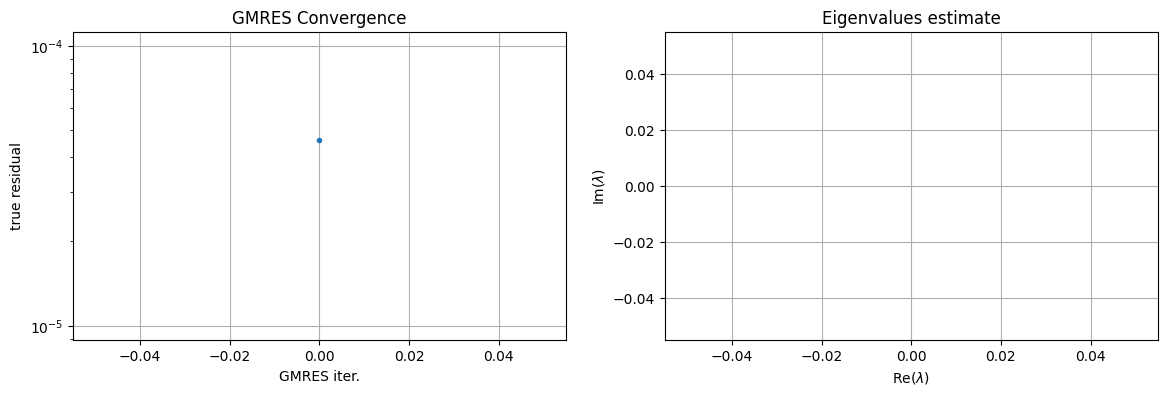

In [19]:
tmp = model.bmat[[0,2,3,6,7,8]]
_ = solve_petsc_new(
    tmp,
    solve_schema=MultiStageScheme(
        groups=[0, 2, 3, 6, 7, 8],
        stages=[
            lambda bmat: RestrictedOperator(
                bmat,
                solve_scheme=FieldSplitScheme(
                    groups=[0, 2, 3],
                    solve=lambda bmat: PetscAMGFlow(bmat[[0, 2, 3]].mat),
                ),
            ),
            lambda bmat: PetscILU(bmat.mat),
        ],
    ),
    rhs_global=rhs,
)

Observation:
* If we do Schur complements inside CPR first stage, factorization must be FULL!
* Or the temperature blocks must go first!

Solve  took: 0.01
True residual permuted: 1.0137500634014667e-11
PETSc Converged Reason: 3


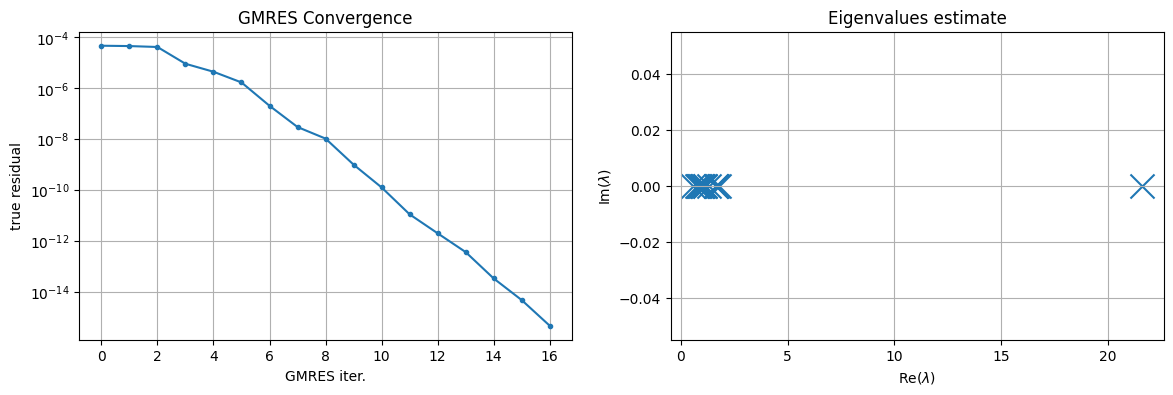

In [20]:
tmp = model.bmat[[0, 2, 3, 6, 7, 8]]

amg_flow = FieldSplitScheme(
    groups=[3],
    solve=lambda bmat: PetscILU(bmat[[3]].mat),
    invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    # factorization_type='full',
    complement=FieldSplitScheme(
        groups=[0, 2],
        solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
    ),
)


_ = solve_petsc_new(
    tmp,
    rhs_global=rhs,
    # solve_schema=MultiStageScheme(
    #     groups=[6, 7, 8, 0, 2, 3],
    #     stages=[
    #         lambda bmat: RestrictedOperator(
    #             bmat,
    #             solve=amg_flow,
    #         ),
    #         lambda bmat: PetscILU(bmat.mat),
    #     ],
    # ),
    solve_schema=FieldSplitScheme(
        groups=[8],
        solve=lambda bmat: PetscILU(bmat[[8]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
        complement=MultiStageScheme(
            groups=[6, 7, 0, 2, 3],
            stages=[
                lambda bmat: RestrictedOperator(
                    bmat,
                    # solve=FieldSplitScheme(
                    #     groups=[0, 2, 3],
                    # ),
                    solve_scheme=amg_flow,
                ),
                lambda bmat: PetscILU(bmat.mat),
            ],
        ),
    ),
)

* It is better to eliminate interfaces before CPR

Solve  took: 1.8
True residual permuted: 1.3497946396117212e-11
PETSc Converged Reason: 3


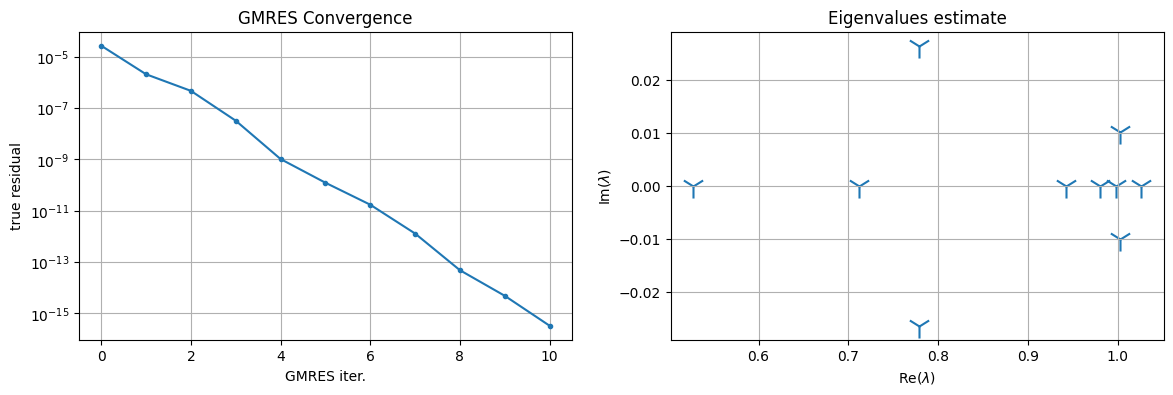

In [39]:
tmp = model.bmat[[0, 2, 3, 6, 7, 8]]

cpr = MultiStageScheme(
    groups=[6, 7, 0, 2],
    stages=[
        lambda bmat: RestrictedOperator(
            bmat,
            solve_scheme=FieldSplitScheme(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
            ),
        ),
        lambda bmat: PetscILU(bmat.mat),
    ],
)

_ = solve_petsc_new(
    tmp,
    rhs_global=rhs,
    # solve_schema=FieldSplitScheme(
    #     groups=[3, 8],
    #     solve=lambda bmat: PetscILU(bmat[[3, 8]].mat),
    #     invertor=lambda bmat: extract_diag_inv(bmat[[3, 8]].mat),
    #     complement=cpr,
    # ),
    solve_schema=FieldSplitScheme(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # only_complement=True,
        complement=FieldSplitScheme(
            groups=[8],
            solve=lambda bmat: PetscILU(bmat[[8]].mat),
            invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
            # only_complement=True,
            complement=cpr,
            # complement=FieldSplitScheme(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
            # )
        ),
    ),
    # solve_schema=FieldSplitScheme(
    #     groups=[8],
    #     solve=lambda bmat: PetscILU(bmat[[8]].mat),
    #     invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
    #     complement=FieldSplitScheme(
    #         groups=[3],
    #         solve=lambda bmat: PetscILU(bmat[[3]].mat),
    #         invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    #         complement=cpr,
    #     ),
    # ),
)

Solve  took: 2.09
True residual permuted: 1.4545935395226603e-11
PETSc Converged Reason: 3


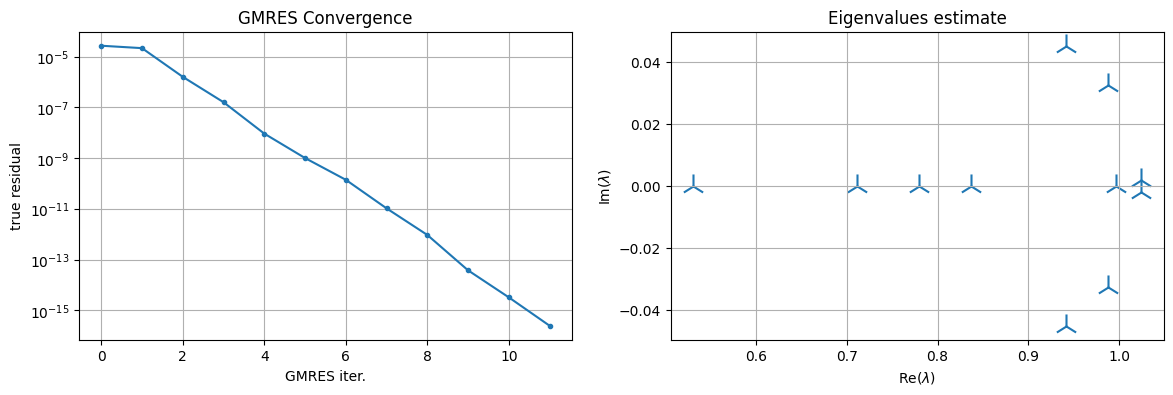

In [41]:
tmp = model.bmat[[0, 2, 3, 6, 7, 8]]

cpr = MultiStageScheme(
    groups=[6, 7, 0, 2],
    stages=[
        lambda bmat: RestrictedOperator(
            bmat,
            # solve=FieldSplitScheme(
            #     groups=[0, 2, 3],
            # ),
            solve_scheme=FieldSplitScheme(
                groups=[0, 2],
                solve=lambda bmat: PetscAMGFlow(bmat[[0, 2]].mat),
            ),
        ),
        lambda bmat: RearrangeAOS(bmat, lambda mat: PetscILU(mat), together=[[6, 7], [0, 2]]),
    ],
)

_ = solve_petsc_new(
    tmp,
    rhs_global=rhs,
    # solve_schema=FieldSplitScheme(
    #     groups=[3, 8],
    #     solve=lambda bmat: PetscILU(bmat[[3, 8]].mat),
    #     invertor=lambda bmat: extract_diag_inv(bmat[[3, 8]].mat),
    #     complement=cpr,
    # ),
    solve_schema=FieldSplitScheme(
        groups=[3],
        solve=lambda bmat: PetscILU(bmat[[3]].mat),
        invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        complement=FieldSplitScheme(
            groups=[8],
            solve=lambda bmat: PetscILU(bmat[[8]].mat),
            invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
            complement=cpr,
        ),
    ),
    # solve_schema=FieldSplitScheme(
    #     groups=[8],
    #     solve=lambda bmat: PetscILU(bmat[[8]].mat),
    #     invertor=lambda bmat: extract_diag_inv(bmat[[8]].mat),
    #     complement=FieldSplitScheme(
    #         groups=[3],
    #         solve=lambda bmat: PetscILU(bmat[[3]].mat),
    #         invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
    #         complement=cpr,
    #     ),
    # ),
)